In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

# Import Dataset 

In [2]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
path  = "C:/Users/User/Downloads/7113.KL(2017-2022).csv"
topGlove = pd.read_csv(path, index_col='Date', parse_dates=['Date'], date_parser=dateparse)

In [3]:
topGlove

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-10-27,1.073333,1.103333,1.071666,1.075000,0.912288,27835200.0
2017-10-30,1.080000,1.091666,1.073333,1.075000,0.912288,7378200.0
2017-10-31,1.083333,1.083333,1.053333,1.066666,0.905216,9283200.0
2017-11-01,1.066666,1.083333,1.065000,1.066666,0.905216,5490600.0
2017-11-02,1.066666,1.080000,1.063333,1.066666,0.905216,10039800.0
...,...,...,...,...,...,...
2021-12-27,2.250000,2.450000,2.210000,2.360000,2.360000,38963400.0
2021-12-28,2.370000,2.410000,2.300000,2.370000,2.370000,18604700.0
2021-12-29,2.380000,2.480000,2.360000,2.410000,2.410000,22588800.0


In [4]:
topGlove.isnull().sum()

Open         1
High         1
Low          1
Close        1
Adj Close    1
Volume       1
dtype: int64

In [5]:
topGlove.fillna(method='ffill', inplace=True)

In [6]:
topGlove.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

# Plot Top Glove Share Price Graph

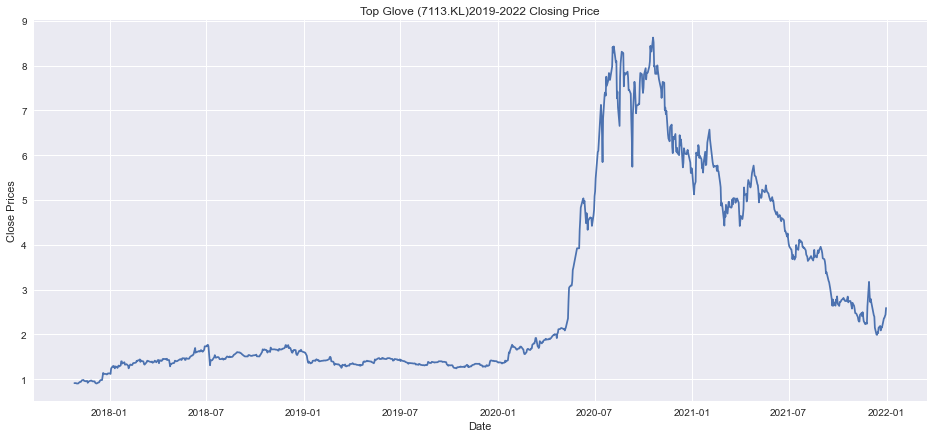

In [7]:
plt.figure(figsize=(16,7))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(topGlove['Adj Close'])
plt.title('Top Glove (7113.KL)2019-2022 Closing Price')
plt.show()

# Dickey-Fuller Test

In [8]:
def adfuller_test(stocks):
    result=adfuller(stocks)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

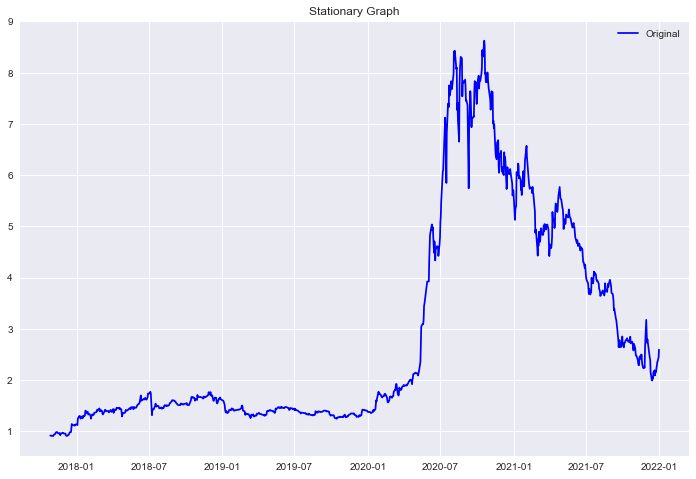

Results of Dickey-Fuller Test:
p-value = 0.5898. The series is likely non-stationary.
Test Statistic                   -1.384358
p-value                           0.589752
#Lags Used                       19.000000
Number of Observations Used    1008.000000
Critical Value (1%)              -3.436854
Critical Value (5%)              -2.864412
Critical Value (10%)             -2.568299
dtype: float64


In [9]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window = 12, cutoff = 0.01):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    #mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    #std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Stationary Graph')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)
    
test_stationarity(topGlove['Adj Close'])

In [10]:
adfuller_test(topGlove['Adj Close'])

ADF Test Statistic : -1.3843583981782095
p-value : 0.5897515040115703
#Lags Used : 19
Number of Observations : 1008


In [11]:
first_diff =topGlove['Adj Close']-topGlove['Adj Close'].shift(1)
first_diff = first_diff.dropna(inplace = False)

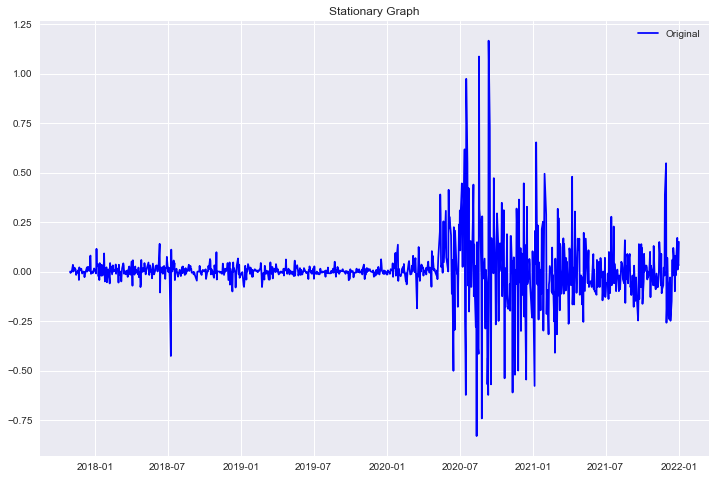

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -6.582493e+00
p-value                        7.453808e-09
#Lags Used                     1.800000e+01
Number of Observations Used    1.008000e+03
Critical Value (1%)           -3.436854e+00
Critical Value (5%)           -2.864412e+00
Critical Value (10%)          -2.568299e+00
dtype: float64


In [12]:
test_stationarity(first_diff, window = 12)

<AxesSubplot:xlabel='Date'>

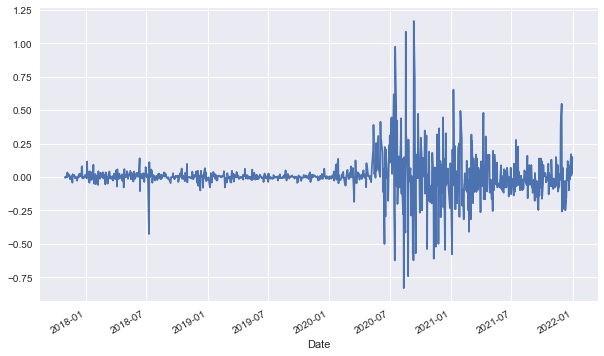

In [13]:
topGlove['Adj Close first difference']=topGlove['Adj Close']-topGlove['Adj Close'].shift(1)
topGlove['Adj Close first difference'].plot()

In [14]:
from statsmodels.tsa.stattools import adfuller

x=topGlove['Adj Close first difference'].dropna() 
result=adfuller(x)
print("ADF Statistic ",result[0])
print("P-value",result[1])
print("critical values",result[5])

ADF Statistic  -5.348826287398825
P-value 4.334593333030893e-06
critical values -1093.6912313685352


# Find Parameter p, d, q

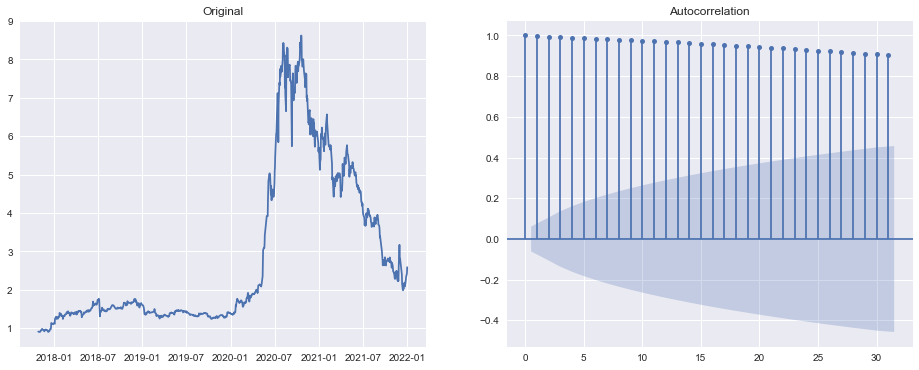

In [15]:
fig, (ax1,ax2) = plt.subplots(1,2 ,figsize=(16,6))

ax1.plot(topGlove['Adj Close'])
ax1.set_title("Original")
plot_acf(topGlove['Adj Close'] , ax=ax2);

In [16]:
#can use other method is pmdarima 
from pmdarima.arima.utils import ndiffs
ndiffs(topGlove['Adj Close'], test="adf")

1

# AR(p) 

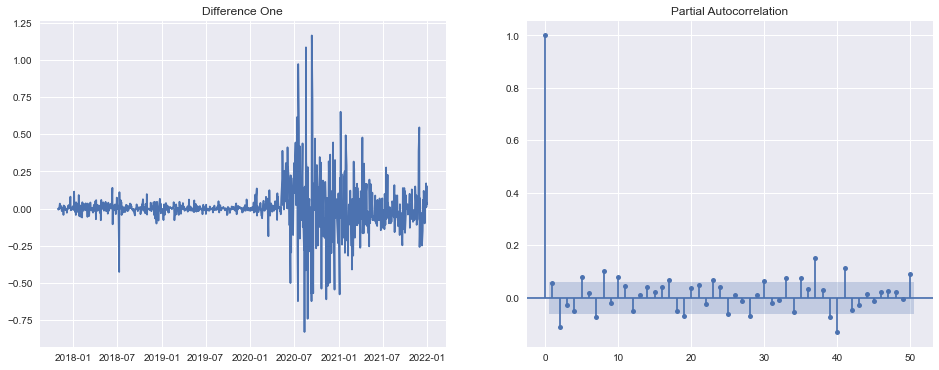

In [17]:
diffOne = topGlove['Adj Close'].diff().dropna()

fig, (ax1,ax2) = plt.subplots(1,2 ,figsize=(16,6))
ax1.plot(diffOne)
ax1.set_title("Difference One")
#ax2.set_ylim(0,1)
plot_pacf(diffOne,lags=50,ax=ax2 );
#AR2 

# MA(q)

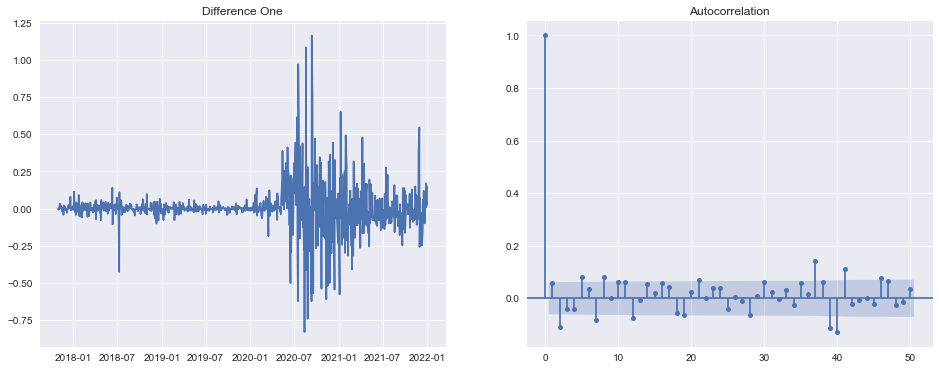

In [18]:
diffOne = topGlove['Adj Close'].diff().dropna()

fig, (ax1,ax2) = plt.subplots(1,2 ,figsize=(16,6))
ax1.plot(diffOne)
ax1.set_title("Difference One")
#ax2.set_ylim(0,1)
plot_acf(diffOne,lags=50,ax=ax2 );
#MA 2 5 7 8

# Split Data

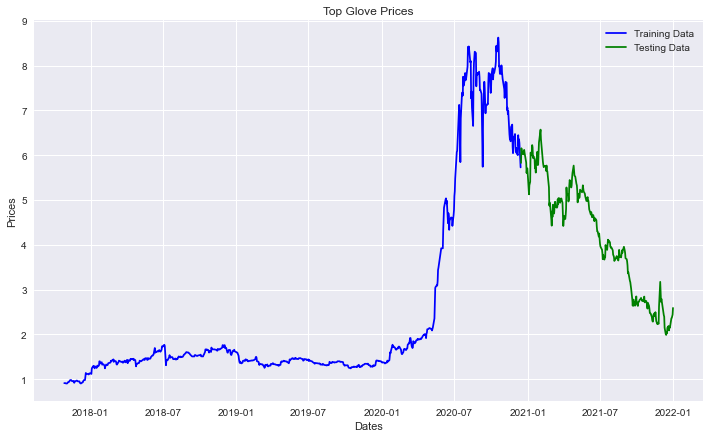

In [19]:
train_data, test_data = topGlove[0:int(len(topGlove)*0.75)], topGlove[int(len(topGlove)*0.75):]


plt.figure(figsize=(12,7))
plt.title('Top Glove Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(train_data['Adj Close'], 'blue', label='Training Data')
plt.plot(test_data['Adj Close'], 'green', label='Testing Data')
plt.legend()

In [21]:


model = ARIMA(train_data['Adj Close'], order=(2, 1, 5))
results = model.fit()

C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\User\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Che

In [22]:
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                  771
Model:                 ARIMA(2, 1, 5)   Log Likelihood                 442.327
Date:                Sat, 29 Apr 2023   AIC                           -868.654
Time:                        18:28:19   BIC                           -831.483
Sample:                             0   HQIC                          -854.349
                                - 771                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7614      0.214      3.565      0.000       0.343       1.180
ar.L2          0.1292      0.199      0.648      0.517      -0.262       0.520
ma.L1         -0.6988      0.214     -3.259      0.0

In [23]:
forecast = results.forecast(steps=len(test_data))

C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


In [24]:
forecast

771     5.715338
772     5.760390
773     5.819660
774     5.846862
775     5.814813
          ...   
1023    5.586210
1024    5.586210
1025    5.586210
1026    5.586210
1027    5.586210
Name: predicted_mean, Length: 257, dtype: float64

In [25]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(test_data['Adj Close'], forecast)
print('MSE:', mse)

MSE: 3.5613131490849086


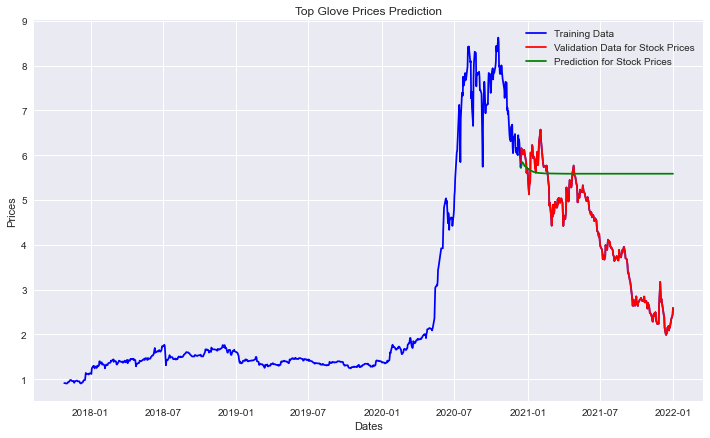

In [26]:
plt.figure(figsize=(12,7))
plt.plot(topGlove['Adj Close'], 'green', color='blue', label='Training Data')
plt.plot(test_data.index,test_data["Adj Close"],'red',label="Validation Data for Stock Prices")
plt.plot(test_data.index, forecast,'green',label="Prediction for Stock Prices")
plt.title('Top Glove Prices Prediction')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.legend()

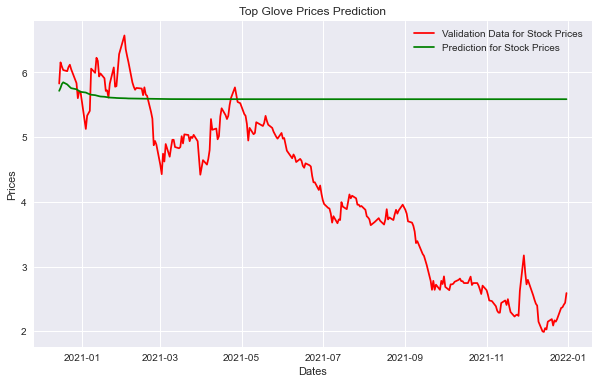

In [27]:
plt.plot(test_data.index,test_data["Adj Close"],'red',label="Validation Data for Stock Prices")
plt.plot(test_data.index, forecast,'green',label="Prediction for Stock Prices")
plt.title('Top Glove Prices Prediction')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.legend()

In [28]:
def smape_kun(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))))

In [33]:
from sklearn.metrics import mean_absolute_percentage_error
error = mean_squared_error(test_data['Adj Close'], forecast)
error2 = smape_kun(test_data['Adj Close'], forecast)
print('Symmetric mean absolute percentage error: %.3f' % error2)


print('=============================================')
print('              Diagnostic Check')
print('=============================================')
mse = mean_squared_error(test_data['Adj Close'], forecast)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data['Adj Close'], forecast)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data['Adj Close'], forecast))
print('RMSE: '+str(rmse))
mape_value = mean_absolute_percentage_error(test_data['Adj Close'], forecast)
print('MAPE:', mape_value)
MSE_error = mean_squared_error(test_data['Adj Close'], forecast)
print('=============================================')
print('Testing Mean Squared Error: %.3f' % error)
print('=============================================')


Symmetric mean absolute percentage error: nan
              Diagnostic Check
MSE: 3.5613131490849086
MAE: 1.5105113891925896
RMSE: 1.8871441781392615
MAPE: 0.5049844199907708
Testing Mean Squared Error: 3.561


In [41]:
import statsmodels.api as sm

residuals = results.resid
lbvalue, pvalue = sm.stats.acorr_ljungbox(residuals, lags=[10])

print('Ljung-Box test:')
print('LB value:', lbvalue)
print('p-value:', pvalue)

Ljung-Box test:
LB value: [15.30641739]
p-value: [0.12128336]
